In [1]:
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pymorphy2
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
morph = pymorphy2.MorphAnalyzer()

In [2]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])#Делаем одинаковое количество негативынх и позиитвных твитов
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)#Соединяем
labels = [1] * sample_size + [0] * sample_size

In [3]:
def replaceemoji_text(text):# Заменяем смайлы
    text = text.replace (":D"," улыбка")
    text = text.replace (":-D"," улыбка")
    text = text.replace ("=)"," улыбка")
    text = text.replace (":)"," улыбка")
    text = text.replace (":-)"," улыбка")
    text = text.replace (";)"," улыбка")
    text = text.replace (":("," грусть")
    text = text.replace (":|"," недоумение")
    text = text.replace (":-("," грусть")
    text = text.replace (":*"," улыбка")
    text = text.replace ("%)"," удивление")
    return text.strip()
raw_data = [replaceemoji_text(t) for t in raw_data]

In [4]:
def ReplaceTreeorMore(text):# Если в слове больше двух одинаковых букв, идущих подрядл, меняем на две одинаковые буквы
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", text)
raw_data = [ReplaceTreeorMore(t) for t in raw_data]

In [5]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")# Меняем ё на е
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)# Меняем ссылки на URL
    text = re.sub('@[^\s]+', 'USER', text)# Пользователя на User
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)# Убираес все прочие занки кроме букв и цифр
    text = re.sub(' +', ' ', text)
    return text.strip()


raw_data = [preprocess_text(t) for t in raw_data]

In [6]:
df = pd.DataFrame(list(zip(raw_data, labels)), # Делаем Dataframe 
               columns =['data', 'labels']) 

In [7]:
df

,data,labels
0,USER хоть я и школота но поверь у нас то же са...,1
1,да все таки он немного похож на него но мой ма...,1
2,rt USER ну ты идиотка я испугалась за тебя,1
3,rt USER кто то в углу сидит и погибает от голо...,1
4,USER вот что значит страшилка улыбка но блин п...,1
...,...,...
223841,но не каждый хочет что то исправлять грусть URL,0
223842,скучаю так грусть только USER вправляет мозги ...,0
223843,вот и в школу в говно это идти уже надо,0
223844,rt USER USER тауриэль не грусти грусть обнял,0


In [8]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
def tokenize_n_normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):# Лемметизируем слова, приводя их к нормальтной форме
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]   

In [9]:
df["data"] = df["data"].map(lambda x: " ".join(tokenize_n_normalize(x)))

In [10]:
df

,data,labels
0,user хоть школотый но поверь мы то же самый ул...,1
1,да весь таки он немного похожий на он но мой м...,1
2,rt user ну ты идиотка испугаться за ты,1
3,rt user кто то угол сидеть погибать от голод м...,1
4,user вот что значит страшилка улыбка но блин п...,1
...,...,...
223841,но не каждый хотеть что то исправлять грусть url,0
223842,скучать так грусть только user вправлять мозги...,0
223843,вот школа говно это идти уже надо,0
223844,rt user user тауриэль не грусть грусть обнять,0


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["data"].apply(tokenizer.tokenize)# Разбиваем на токены

In [12]:
df.head(10)

,data,labels,tokens
0,user хоть школотый но поверь мы то же самый ул...,1,"[user, хоть, школотый, но, поверь, мы, то, же,..."
1,да весь таки он немного похожий на он но мой м...,1,"[да, весь, таки, он, немного, похожий, на, он,..."
2,rt user ну ты идиотка испугаться за ты,1,"[rt, user, ну, ты, идиотка, испугаться, за, ты]"
3,rt user кто то угол сидеть погибать от голод м...,1,"[rt, user, кто, то, угол, сидеть, погибать, от..."
4,user вот что значит страшилка улыбка но блин п...,1,"[user, вот, что, значит, страшилка, улыбка, но..."
5,ну любить или нет не знать кто ты бля улыбка url,1,"[ну, любить, или, нет, не, знать, кто, ты, бля..."
6,rt user ох улыбка ну это конечно же user чтобы...,1,"[rt, user, ох, улыбка, ну, это, конечно, же, u..."
7,rt user ты есть ухажёр нет мой ухо не кто не ж...,1,"[rt, user, ты, есть, ухажёр, нет, мой, ухо, не..."
8,поприветствовать мой новое читатель user улыбка,1,"[поприветствовать, мой, новое, читатель, user,..."
9,теперь я есть частичка сидней улыбка sydney sy...,1,"[теперь, я, есть, частичка, сидней, улыбка, sy..."


In [13]:
stop = stopwords.words('russian')

In [14]:
df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop]) # Удаляем stop слова

In [15]:
df

,data,labels,tokens
0,user хоть школотый но поверь мы то же самый ул...,1,"[user, школотый, поверь, самый, улыбка, общест..."
1,да весь таки он немного похожий на он но мой м...,1,"[весь, таки, немного, похожий, мальчик, весь, ..."
2,rt user ну ты идиотка испугаться за ты,1,"[rt, user, идиотка, испугаться]"
3,rt user кто то угол сидеть погибать от голод м...,1,"[rt, user, угол, сидеть, погибать, голод, ещё,..."
4,user вот что значит страшилка улыбка но блин п...,1,"[user, значит, страшилка, улыбка, блин, посмот..."
...,...,...,...
223841,но не каждый хотеть что то исправлять грусть url,0,"[каждый, хотеть, исправлять, грусть, url]"
223842,скучать так грусть только user вправлять мозги...,0,"[скучать, грусть, user, вправлять, мозги, весь..."
223843,вот школа говно это идти уже надо,0,"[школа, говно, это, идти]"
223844,rt user user тауриэль не грусть грусть обнять,0,"[rt, user, user, тауриэль, грусть, грусть, обн..."


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data): # Bag of words модель 
    count_vectorizer = CountVectorizer(tokenizer=lambda doc: doc,lowercase=False)

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["tokens"].tolist()
list_labels = df["labels"].tolist()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus,list_labels, test_size=0.2, 
                                                                                random_state=40) # Разбиваем слова на тренировочную и тестовую

In [18]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

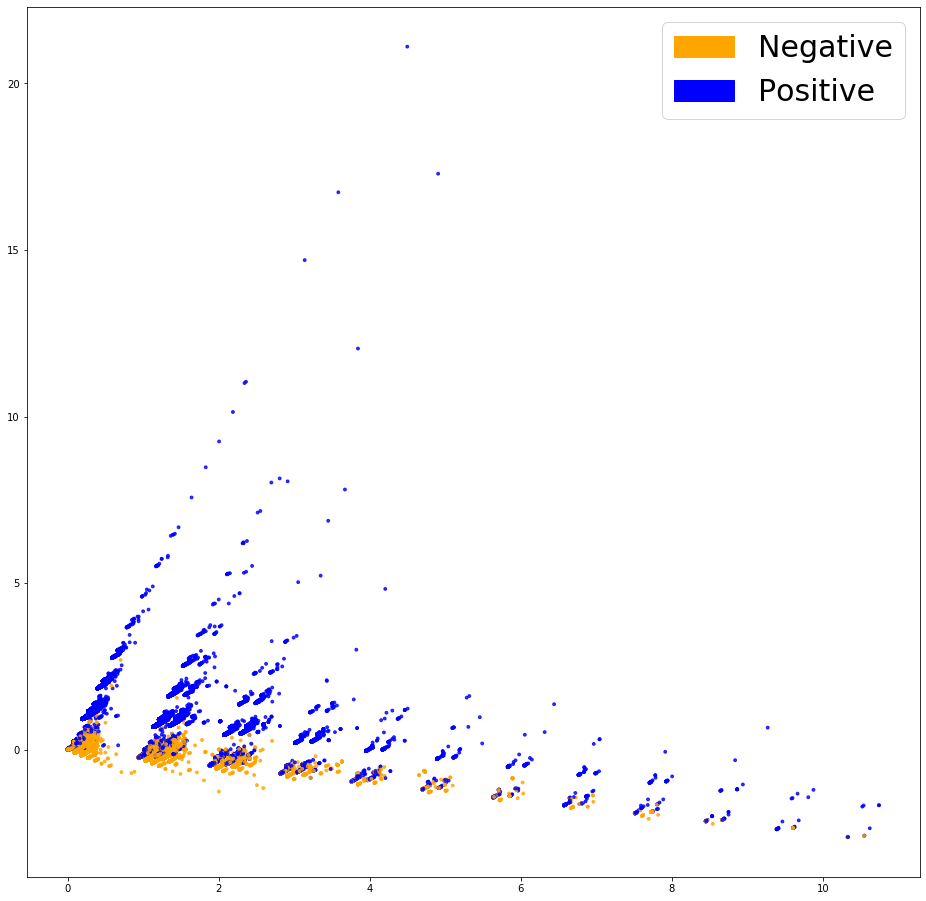

In [21]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True): # Смотрим как классы разделены
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Negative')
            green_patch = mpatches.Patch(color='blue', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression # Логистическая регрессия

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [23]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_predicted_counts, digits=5))

              precision    recall  f1-score   support

           0    0.81462   0.83940   0.82683     22522
           1    0.83226   0.80663   0.81925     22248

    accuracy                        0.82312     44770
   macro avg    0.82344   0.82302   0.82304     44770
weighted avg    0.82339   0.82312   0.82306     44770



In [46]:
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

#def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
   # precision = precision_score(y_test, y_predicted, pos_label=None,
                                    #average='weighted')             
    # true positives / (true positives + false negatives)
    #recall = recall_score(y_test, y_predicted, pos_label=None,
                              #average='weighted')
    
    # harmonic mean of precision and recall
   # f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    #accuracy = accuracy_score(y_test, y_predicted)
    #return accuracy, precision, recall, f1

#accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.823, precision = 0.823, recall = 0.823, f1 = 0.823


In [19]:
def tfidf(data): # Tf-IDF модель
    tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc,lowercase=False)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

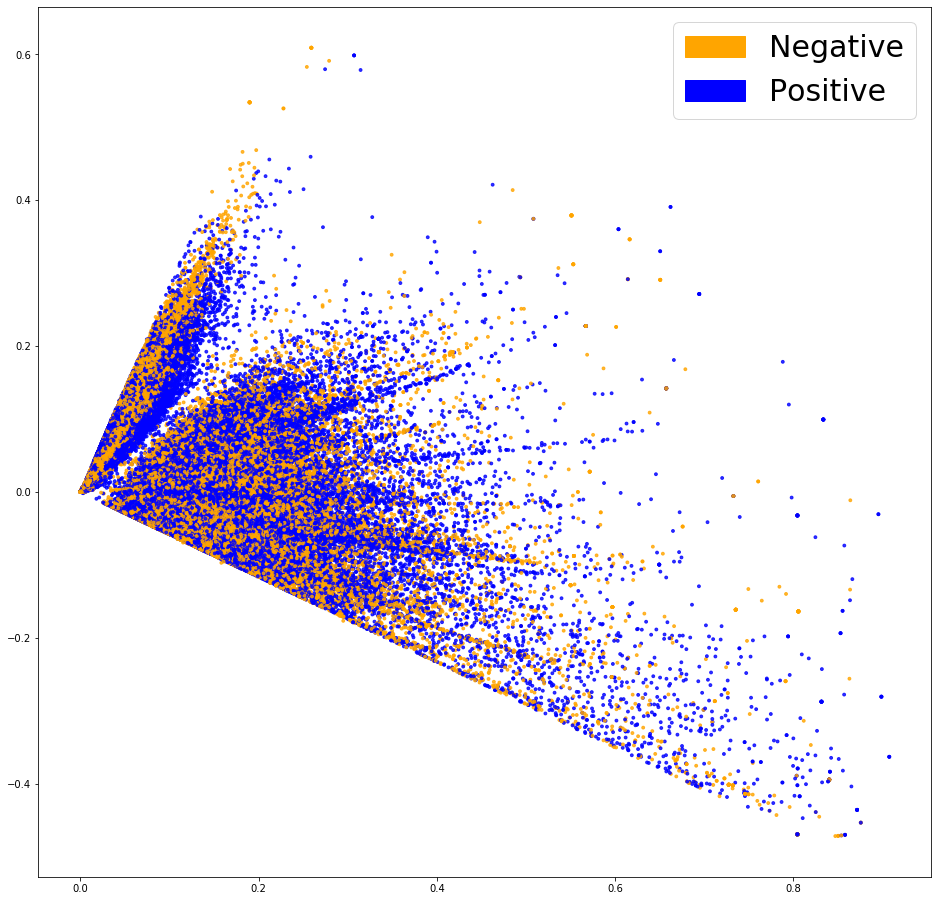

In [26]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [27]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', # Логистическая решрессия к TF-IDf модели
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [28]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_predicted_tfidf, digits=5))

              precision    recall  f1-score   support

           0    0.81970   0.83350   0.82654     22522
           1    0.82852   0.81441   0.82141     22248

    accuracy                        0.82401     44770
   macro avg    0.82411   0.82395   0.82397     44770
weighted avg    0.82409   0.82401   0.82399     44770



In [20]:
from sklearn import svm # SVM к TF IDf модели
from sklearn.svm import LinearSVC
classifier_linearSVC = LinearSVC()
classifier_linearSVC.fit(X_train_tfidf, y_train)
y_predictedSVCtfidf = classifier_linearSVC.predict(X_test_tfidf)

In [21]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_predictedSVCtfidf, digits=5))

              precision    recall  f1-score   support

           0    0.82733   0.83478   0.83104     22522
           1    0.83121   0.82362   0.82740     22248

    accuracy                        0.82924     44770
   macro avg    0.82927   0.82920   0.82922     44770
weighted avg    0.82926   0.82924   0.82923     44770

